In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections, numpy

In [8]:
%matplotlib notebook

In [9]:
def read_file(subject_id):
    subject_data = {}
    with pd.HDFStore('./data/subject_{}.h5'.format(subject_id)) as hdfs:
        subject_data.update({'Acceleration':np.array(hdfs['Acceleration'].value)})
        subject_data.update({'Acceleration_Index':np.array(hdfs['Acceleration'].index)})
        subject_data.update({'Heart_Rate':np.array(hdfs['Heart_Rate']['value'])})
        subject_data.update({'Heart_Rate_Confidence':np.array(hdfs['Heart_Rate']['conf'])})
        subject_data.update({'Heart_Rate_Index':np.array(hdfs['Heart_Rate'].index)})
        subject_data.update({'Breathing_Rate':np.array(hdfs['Breathing_Rate']['value'])})
        subject_data.update({'Breathing_Rate_Confidence':np.array(hdfs['Breathing_Rate']['conf'])})
        subject_data.update({'Breathing_Rate_Index':np.array(hdfs['Breathing_Rate'].index)})
        subject_data.update({'RR_Interval':np.array(hdfs['RR_Interval']['value'])})
        subject_data.update({'RR_Interval_Confidence':np.array(hdfs['RR_Interval']['conf'])})
        subject_data.update({'RR_Interval_Index':np.array(hdfs['RR_Interval'].index)})
        subject_data.update({'Sleep_Stages':np.array(hdfs['Sleep_Stages'].value)})
        subject_data.update({'Sleep_Stages_Index':np.array(hdfs['Sleep_Stages'].index)})
        subject_data.update({'Profile_Age':hdfs['Profile']['age'].tolist()[0]})
        subject_data.update({'Profile_Gender':hdfs['Profile']['gender'].tolist()[0]})
        subject_data.update({'Profile_Weight':hdfs['Profile']['weight'].tolist()[0]})
        subject_data.update({'Profile_Height':hdfs['Profile']['height'].tolist()[0]})
        subject_data.update({'Profile_Blood_Pressure_Systolic':hdfs['Profile']['blood_pressure_systolic'].tolist()[0]})
        subject_data.update({'Profile_Blood_Pressure_Diastolic':hdfs['Profile']['blood_pressure_diastolic'].tolist()[0]})
        subject_data.update({'Profile_Cholesterol':hdfs['Profile']['cholesterol'].tolist()[0]})
        subject_data.update({'Profile_Smoker':hdfs['Profile']['smoker'].tolist()[0]})
        
    return(subject_data)

In [10]:
all_subject_data = {}
for i in range(10):
    all_subject_data.update({'subject{}'.format(i):read_file(i)})

In [69]:

subject_data = all_subject_data['subject9']

In [70]:
print("Age : " + str(subject_data['Profile_Age']))
print("Gender : " + str(subject_data['Profile_Gender']))
print("Weight : " + str(subject_data['Profile_Weight']))
print("Height : " + str(subject_data['Profile_Height']))
print("Cholesterol : " + str(subject_data['Profile_Cholesterol']))
print("Blood Pressure Systolic : " + str(subject_data['Profile_Blood_Pressure_Systolic']))
print("Blood Pressure Diastolic : " + str(subject_data['Profile_Blood_Pressure_Diastolic']))
print("Smoker : " + str(subject_data['Profile_Smoker']))

Age : 48
Gender : Female
Weight : 72.0
Height : 175.0
Cholesterol : 7.43
Blood Pressure Systolic : 120
Blood Pressure Diastolic : 70
Smoker : No


In [71]:
"""
cholesterol scores are adjusted for sex
"""
gender = (subject_data['Profile_Gender'])
chol = (subject_data['Profile_Cholesterol'])

if gender == 'Female':
    if chol <3:
        print('low risk, 15')
    elif chol >= 3 and chol < 4.4:
        print('medium risk, score 8')
    else:
        print('high risk, score 3')

if gender == 'Male':
    if chol <3.5:
        print('low risk, 15')
    elif chol >= 3.5 and chol <= 5:
        print('medium risk, score 8')
    else:
        print('high risk, score 3')

high risk, score 3


In [72]:
BMI_denominator = ((subject_data['Profile_Height'])/100)**2
BMI = (subject_data['Profile_Weight'])/BMI_denominator
print(BMI) 

"""
BMI is detrimental when it is above the "normal range"
I want to create a weighted penalty to the 'health score' for distance from the "normal range"
"""
if BMI <= 18.5:
    print('low risk, score 18')

elif BMI > 18.5 and BMI < 30:
    print('low risk, score 18')

elif BMI > 30 and BMI < 35:
    print('medium risk, score 12')

elif BMI > 35 and BMI < 40:
    print('high risk, score 6')
else:
    print('very high risk, score 0')

23.5102040816
low risk, score 18


In [73]:
"""
blood pressure penalty
"""
BP_sys = (subject_data['Profile_Blood_Pressure_Systolic'])
BP_dia = (subject_data['Profile_Blood_Pressure_Diastolic'])

if BP_sys >= 90 and BP_sys <= 120 and BP_dia >=60 and BP_dia <=80:
    print('low risk, score 15')

elif BP_sys < 90 and BP_sys > 120 and BP_sys <130 and BP_dia < 60 and BP_dia > 80 and BP_dia <=90:
    print('medium risk, 8')

else:
    print('high risk, 3')


low risk, score 15


<IPython.core.display.Javascript object>


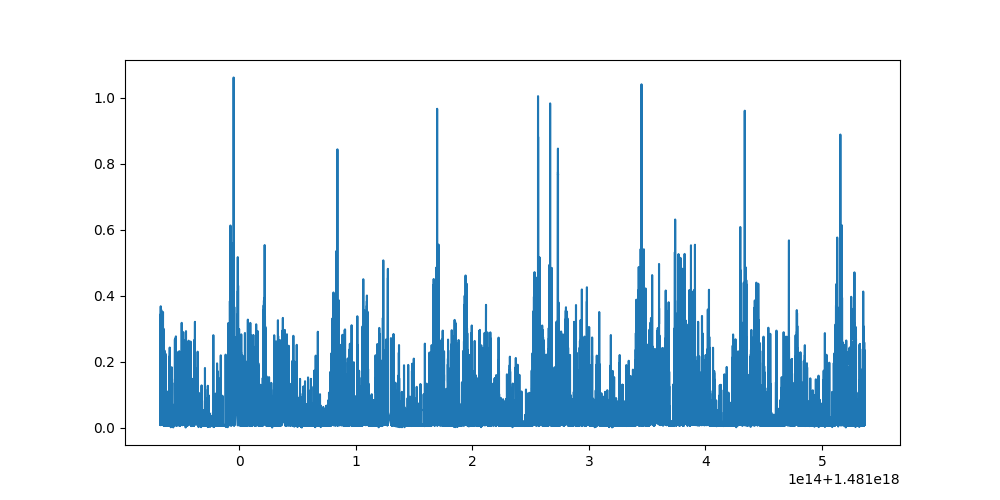

In [74]:
plt.figure(figsize=(10,5))
plt.plot(subject_data['Acceleration_Index'], subject_data['Acceleration'])
plt.show()

<IPython.core.display.Javascript object>


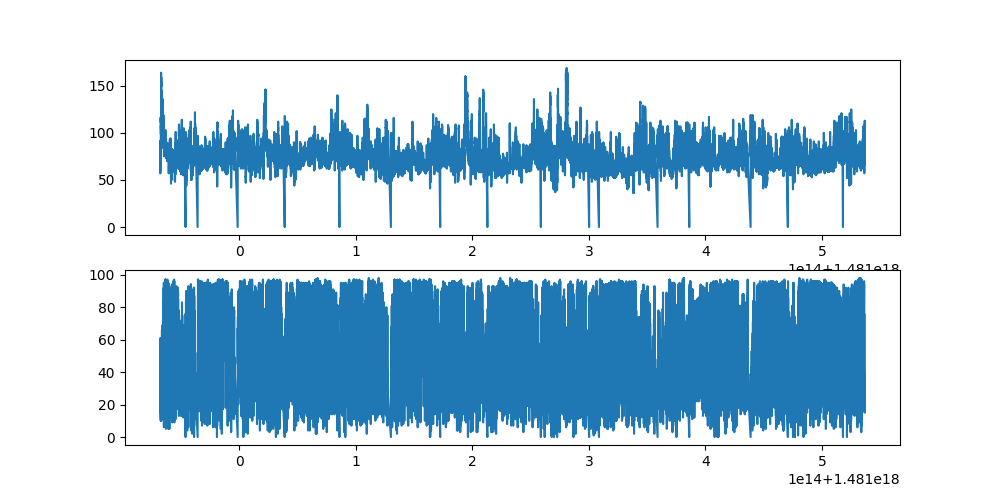

In [75]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(subject_data['Heart_Rate_Index'], subject_data['Heart_Rate'])
plt.subplot(212)
plt.plot(subject_data['Heart_Rate_Index'], subject_data['Heart_Rate_Confidence'])
plt.show()

In [76]:
##detecting confidence score outliers 
def find_anomalies(data):
    anomalies = []
    data_std = np.std(data)
    data_mean = np.mean(data)
    anomaly_cut_off = data_std * 2

    lower_limit  = data_mean - anomaly_cut_off 
    upper_limit = data_mean + anomaly_cut_off
    print(lower_limit)


    for outlier in data:
        if outlier > upper_limit or outlier < lower_limit:
            anomalies.append(outlier)
    return anomalies


In [77]:
'''
When calculating RHR we want to exclude:
i)low confidence score reads from the HR stream
ii) HR that are higher than the norm reflecxting physical activity, 
and HR that is lower than 2 std deviation reflecting sleep(I wanted to use the timestamp for the breathing but ran out of time)
(this was incredibly hacky-running out of time)


'''

confidence = (subject_data['Heart_Rate_Confidence']) 
HR = (subject_data['Heart_Rate'])
HR_index = (subject_data['Heart_Rate_Index'])


array = np.concatenate((confidence.reshape(-1,1),HR.reshape(-1,1)),axis=1)
                       
confidence_anomalies = find_anomalies(confidence)
HR_anomalies = find_anomalies(HR)


###excluding low confidence read timestamps

column_vals = ['confidence', 'HR']
df = pd.DataFrame(data=array, index=HR_index, columns=column_vals)


df2 = df[~df['confidence'].isin(confidence_anomalies)]
df3 = df2[~df2['HR'].isin(HR_anomalies)]

####mean HR excluding outliers
mean_HR = df3['HR'].mean()

print(mean_HR)


7.663289260611343
49.40115139443158
73.57896799078313


In [78]:
###determining risk score for RHR:
gender = (subject_data['Profile_Gender'])

if gender == 'Female':
    if mean_HR < 68:
        print('low risk, 18')
    elif mean_HR >= 69 and  mean_HR < 83:
        print('medium risk, score 12')
    else:
        print('high risk, score 6')

if gender == 'Male':
    if mean_HR < 61:
        print('low risk, 18')
    elif mean_HR >= 62 and mean_HR <= 82:
        print('medium risk, score 12')
    else:
        print('high risk, score 6')

medium risk, score 12


<IPython.core.display.Javascript object>


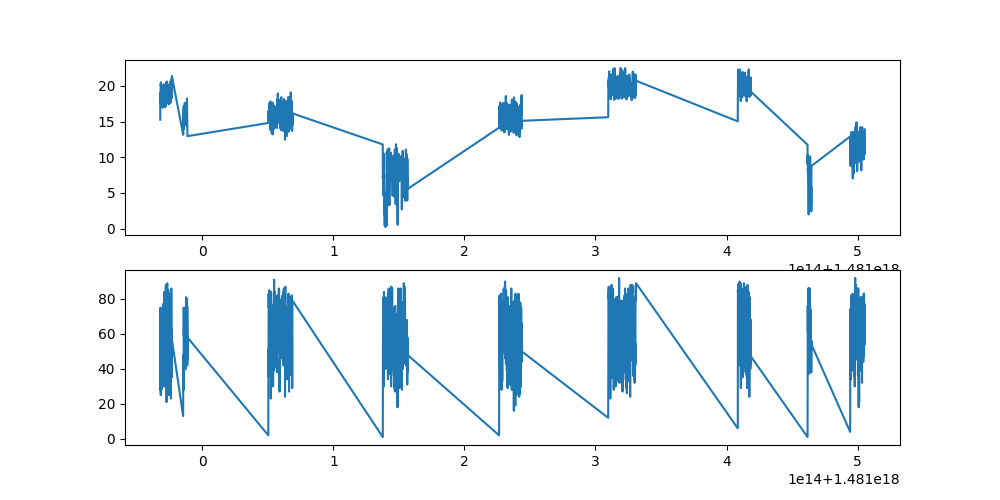

In [79]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(subject_data['Breathing_Rate_Index'], subject_data['Breathing_Rate'])
plt.subplot(212)
plt.plot(subject_data['Breathing_Rate_Index'], subject_data['Breathing_Rate_Confidence'])
plt.show()

<IPython.core.display.Javascript object>


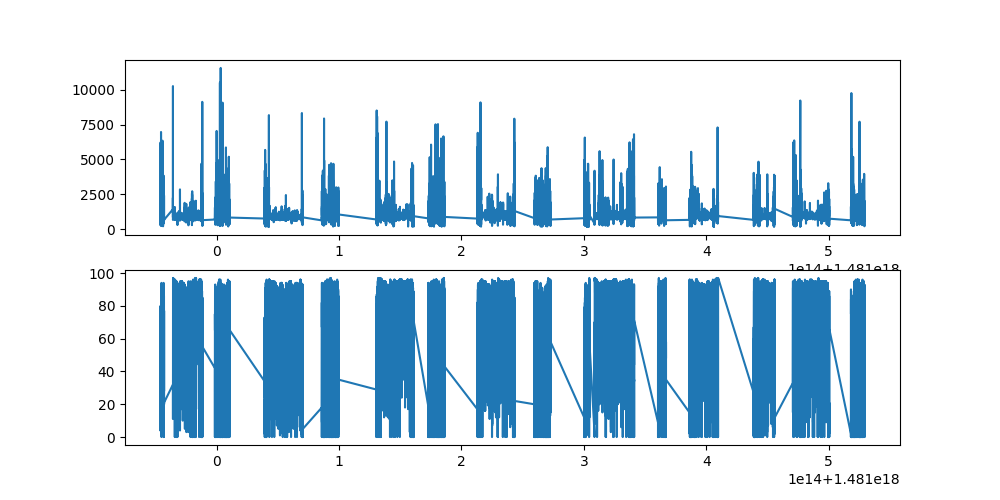

In [80]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(subject_data['RR_Interval_Index'], subject_data['RR_Interval'])
plt.subplot(212)
plt.plot(subject_data['RR_Interval_Index'], subject_data['RR_Interval_Confidence'])
plt.show()

<IPython.core.display.Javascript object>


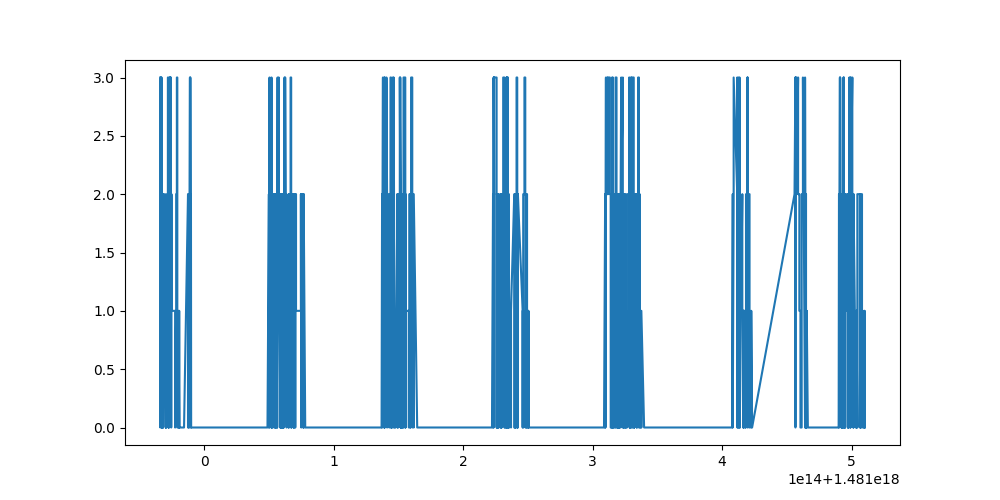

In [81]:
tmp_sleep_stages = subject_data['Sleep_Stages']
tmp_sleep_stages[tmp_sleep_stages == 'sleep_wake_start'] = 0
tmp_sleep_stages[tmp_sleep_stages == 'sleep_wake_stop'] = 0
tmp_sleep_stages[tmp_sleep_stages == 'sleep_rem_start'] = 1
tmp_sleep_stages[tmp_sleep_stages == 'sleep_rem_stop'] = 1
tmp_sleep_stages[tmp_sleep_stages == 'sleep_light_start'] = 2
tmp_sleep_stages[tmp_sleep_stages == 'sleep_light_stop'] = 2
tmp_sleep_stages[tmp_sleep_stages == 'sleep_deep_start'] = 3
tmp_sleep_stages[tmp_sleep_stages == 'sleep_deep_stop'] = 3
plt.figure(figsize=(10,5))
plt.plot(subject_data['Sleep_Stages_Index'], tmp_sleep_stages)
plt.show()

In [82]:
"""
Good sleep quality is correlated with reduced mortality, 

The total number of tokens do not have a consuitent number across datasets, 
therefore we can deduce that they dont equate to time intervals at each stage.
the deep sleep ratio will be determine by the number of deep sleep tokens to total sleep tokens. 

Ran out of time to do the hours of sleep using the timestamp. 

"""
tmp_sleep_stages = (subject_data['Sleep_Stages'])

rem_sleep = np.count_nonzero(tmp_sleep_stages == 1)
light_sleep = np.count_nonzero(tmp_sleep_stages == 2)
deep_sleep = np.count_nonzero(tmp_sleep_stages == 3)
total_sleep= rem_sleep + light_sleep

deep_sleep_ratio = (deep_sleep/float(total_sleep))

if deep_sleep_ratio >=0.3:
    print('low risk, score 16')
elif deep_sleep_ratio < 0.3 and deep_sleep_ratio > 0.1:
    print('medium risk, score 9')
else: 
    print('high risk, score 3')

medium risk, score 9
